In [ ]:
# Connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import sqlite3
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

from xgboost import XGBRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
import pickle
import time
import gc
import datetime

# Load Data

In [ ]:
# Load DB Data into dataframe

import sqlite3
import pandas as pd

path = "drive/My Drive/3001 Proj/database.db"
connection = sqlite3.connect(path)
cursor = connection.cursor()

# symbol1, symbol2 = 'BTC-USDT', 'BTC-USD-220930'
symbol1, symbol2 = 'BTC-USDT', 'BTC-USDT-SWAP'

sqline = f"SELECT * from dbtickdata WHERE symbol == '{symbol1}' OR symbol == '{symbol2}'"

df = pd.read_sql((sqline), con=connection)

df

,id,symbol,exchange,datetime,name,volume,turnover,open_interest,last_price,last_volume,...,bid_volume_2,bid_volume_3,bid_volume_4,bid_volume_5,ask_volume_1,ask_volume_2,ask_volume_3,ask_volume_4,ask_volume_5,localtime
0,14,BTC-USDT,OKEX,2022-04-19 20:21:46.644000,BTC-USDT,1.846652e+05,0.0,0.0,41457.4,0.0,...,6.410916,0.033378,4.076022,12.378593,3.885195,11.497862,8.401857,14.410392,3.577806,None
1,15,BTC-USDT,OKEX,2022-04-19 20:21:47.140000,BTC-USDT,1.846652e+05,0.0,0.0,41457.4,0.0,...,6.410916,0.033378,6.933472,2.572136,3.885195,11.497862,11.332299,2.443215,9.275718,None
2,16,BTC-USDT,OKEX,2022-04-19 20:21:47.640000,BTC-USDT,1.846652e+05,0.0,0.0,41457.4,0.0,...,12.997561,9.353024,3.834040,3.303880,6.340388,10.514896,3.885195,2.443215,9.275718,None
3,17,BTC-USDT,OKEX,2022-04-19 20:21:48.153000,BTC-USDT,1.846653e+05,0.0,0.0,41453.3,0.0,...,12.997561,9.353024,3.834040,3.303880,6.340388,10.514896,3.885195,4.394001,2.443215,None
4,18,BTC-USDT,OKEX,2022-04-19 20:21:48.645000,BTC-USDT,1.846653e+05,0.0,0.0,41453.3,0.0,...,6.703542,3.303880,3.944892,11.288417,6.340388,10.514896,5.900318,13.471448,4.847855,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910869,2802095,BTC-USDT-SWAP,OKEX,2022-04-22 21:21:37.546000,BTC-USDT-SWAP,2.033791e+07,0.0,0.0,39580.8,0.0,...,101.000000,109.000000,243.000000,544.000000,238.000000,51.000000,597.000000,281.000000,534.000000,None
910870,2802096,BTC-USDT-SWAP,OKEX,2022-04-22 21:21:37.552000,BTC-USDT-SWAP,2.033791e+07,0.0,0.0,39580.8,0.0,...,101.000000,109.000000,243.000000,544.000000,238.000000,51.000000,597.000000,281.000000,534.000000,None
910871,2802097,BTC-USDT-SWAP,OKEX,2022-04-22 21:21:39.546000,BTC-USDT-SWAP,2.033791e+07,0.0,0.0,39580.8,0.0,...,101.000000,157.000000,207.000000,243.000000,238.000000,51.000000,597.000000,281.000000,124.000000,None
910872,2802098,BTC-USDT-SWAP,OKEX,2022-04-22 21:21:41.548000,BTC-USDT-SWAP,2.033791e+07,0.0,0.0,39580.8,0.0,...,117.000000,300.000000,420.000000,312.000000,438.000000,125.000000,288.000000,519.000000,16.000000,None


## Add Features

In [ ]:
# Features
# Spread
df["level_spread"] = df['ask_price_1'] - df['bid_price_1']

# MidPrice
df["mid_price"] = (df['ask_price_1'] + df['bid_price_1']) / 2

# Relative Spread
df["relative_spread"] = df["level_spread"] / df["mid_price"]

# Order imbalance
df["order_imbalance"] = df['bid_volume_1'] - df['ask_volume_1']

# Order imbalance ratio
df["order_imb_ratio"] = df["order_imbalance"]/(df['bid_volume_1'] + df['ask_volume_1'])

## Resample

In [ ]:
selected_columns = ['symbol', 'datetime', ' ead', 'order_imb_ratio']

df_1 = df[df['symbol'] == symbol1][selected_columns]
df_2 = df[df['symbol'] == symbol2][selected_columns]

# convert df_BTC datetime to datetime
df_1['datetime'] = pd.to_datetime(df_1['datetime'])
df_1.set_index('datetime', inplace=True)

df_2['datetime'] = pd.to_datetime(df_2['datetime'])
df_2.set_index('datetime', inplace=True)


agg_dict = {
    'symbol': 'last',    
    'volume': 'sum',
    'mid_price': 'last',
    'relative_spread': 'last',
    'order_imb_ratio': 'last',
  }

df_1 = (df_1.resample('1S').agg(agg_dict))
df_2 = (df_2.resample('1S').agg(agg_dict))

df_1['volume'] = df_1['volume'].fillna(0)
df_2['volume'] = df_2['volume'].fillna(0)

df_1 = df_1.fillna(method='ffill')
df_2 = df_2.fillna(method='ffill')

df_1.head()

,symbol,volume,mid_price,relative_spread,order_imb_ratio
datetime,,,,,
2022-04-19 20:21:46,BTC-USDT,184665.221512,41454.75,0.000002,0.039407
2022-04-19 20:21:47,BTC-USDT,369330.443024,41449.35,0.000002,-0.234449
2022-04-19 20:21:48,BTC-USDT,369330.509781,41449.35,0.000002,-0.234449
2022-04-19 20:21:49,BTC-USDT,369330.509781,41447.90,0.000072,0.180777
2022-04-19 20:21:50,BTC-USDT,369330.509781,41446.45,0.000002,0.258184


In [ ]:
df_all = df_1.merge(df_2, how='outer', left_index=True, right_index=True, suffixes=('_1', '_2')).dropna()
df_all['price_ratio'] =  df_all['mid_price_1']/df_all['mid_price_2']

lookback = [5, 10, 20, 60, 120]
for lb in lookback:
  df_all[f'change_{lb}'] = df_all['price_ratio'].pct_change(lb)

df_all['forward_change'] = df_all['price_ratio'].pct_change(30).shift(-30)
df_all = df_all.dropna()
df_all.head()

,symbol_1,volume_1,mid_price_1,relative_spread_1,order_imb_ratio_1,symbol_2,volume_2,mid_price_2,relative_spread_2,order_imb_ratio_2,price_ratio,change_5,change_10,change_20,change_60,change_120,forward_change
datetime,,,,,,,,,,,,,,,,,
2022-04-19 20:23:46,BTC-USDT,184859.043951,41333.35,0.000002,0.095473,BTC-USDT-SWAP,13539214.0,41328.05,0.000027,0.597122,1.000128,0.000007,0.002167,0.000693,0.022121,-0.000226,-0.000189
2022-04-19 20:23:47,BTC-USDT,369734.259100,41336.40,0.000063,0.244161,BTC-USDT-SWAP,0.0,41328.05,0.000027,0.597122,1.000202,0.000081,0.000226,0.000104,0.022264,0.000011,-0.000242
2022-04-19 20:23:48,BTC-USDT,184875.215148,41336.85,0.000002,-0.406494,BTC-USDT-SWAP,27079764.0,41331.55,0.000148,0.940120,1.000128,-0.000029,0.000152,0.000125,0.021109,-0.000062,-0.000168
2022-04-19 20:23:49,BTC-USDT,184875.215148,41336.85,0.000002,-0.406494,BTC-USDT-SWAP,0.0,41331.55,0.000148,0.940120,1.000128,0.000012,0.000007,0.000125,0.021109,-0.000027,-0.000168
2022-04-19 20:23:50,BTC-USDT,369750.430296,41336.05,0.000002,-0.175150,BTC-USDT-SWAP,13540550.0,41380.10,0.001213,0.988462,0.998935,-0.001193,-0.001185,-0.001084,0.010976,-0.001214,0.001026


## Clean data

Futures contract is illiquid. So we find the price ratio might be misleading. We will remove such points.

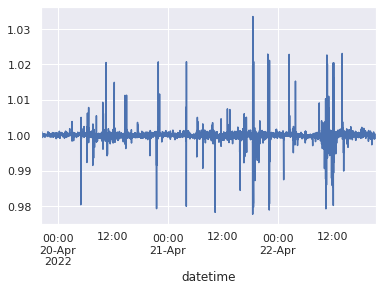

In [ ]:
df_all['price_ratio'].plot()

In [ ]:
# df_all = df_all[df_all['change_5'].between(-0.01, 0.01)]

# Train test split

2022/4/22 for test

In [ ]:
np.unique(df_all.index.date)

array([datetime.date(2022, 4, 19), datetime.date(2022, 4, 20),
       datetime.date(2022, 4, 21), datetime.date(2022, 4, 22)],
      dtype=object)

In [ ]:
df_train, df_test = df_all[df_all.index.date<datetime.date(2022,4,22)], df_all[df_all.index.date==datetime.date(2022,4,22)]
df_all.shape, df_train.shape, df_test.shape

((262646, 17), (185774, 17), (76872, 17))

In [ ]:
features = ['relative_spread_1', 'relative_spread_2', 'order_imb_ratio_1', 'order_imb_ratio_2', 'change_10', 'change_20', 'change_60']
# features = ['order_imb_ratio_1', 'order_imb_ratio_2', 'change_10', 'change_20', 'change_60']
# features = ['change_10', 'change_20', 'change_60']
X_train, y_train = df_train[features], df_train['forward_change']
X_test, y_test = df_test[features], df_test['forward_change']

In [ ]:
X_train

,relative_spread_1,relative_spread_2,order_imb_ratio_1,order_imb_ratio_2,change_10,change_20,change_60
datetime,,,,,,,
2022-04-19 20:23:46,0.000002,0.000027,0.095473,0.597122,0.002167,6.926152e-04,0.022121
2022-04-19 20:23:47,0.000063,0.000027,0.244161,0.597122,0.000226,1.041146e-04,0.022264
2022-04-19 20:23:48,0.000002,0.000148,-0.406494,0.940120,0.000152,1.246043e-04,0.021109
2022-04-19 20:23:49,0.000002,0.000148,-0.406494,0.940120,0.000007,1.246043e-04,0.021109
2022-04-19 20:23:50,0.000002,0.001213,-0.175150,0.988462,-0.001185,-1.083842e-03,0.010976
...,...,...,...,...,...,...,...
2022-04-21 23:59:55,0.000002,0.000002,-0.287241,0.261456,0.000026,8.147827e-05,0.000170
2022-04-21 23:59:56,0.000002,0.000002,-0.287241,0.261456,0.000062,8.147827e-05,0.000104
2022-04-21 23:59:57,0.000002,0.000002,-0.287190,0.261456,0.000062,8.147827e-05,0.000104


# Building Models

In [ ]:
def run_model(model, save_model=False,  model_name=''):
    t1 = time.time()
    model.fit(X_train, y_train)
    t2 = time.time()
    train_time = t2-t1

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    

    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    # r2_train = model.score(X_train, y_train)
    # r2_test = model.score(X_test, y_test)

    IC_train = np.corrcoef(y_train, y_pred_train)[0][1]
    IC_test = np.corrcoef(y_test, y_pred_test)[0][1]
    
    print("test MAE: ", mae)
    print("test MSE: ", mse)

    print("train R2: ", r2_train)
    print("test R2: ", r2_test)

    print("train IC: ", IC_train)
    print("test IC: ", IC_test)

    print("train time: ", train_time)


    pnl_train = np.cumsum(np.sign(y_pred_train) * y_train)
    plt.figure(figsize=(10,6))
    plt.plot(y_train.index, pnl_train)
    plt.xlabel('Time')
    plt.ylabel('PnL')
    plt.title('Backtest for train set')

    pnl_test = np.cumsum(np.sign(y_pred_test) * y_test)
    plt.figure(figsize=(10,6))
    plt.plot(y_test.index, pnl_test)
    plt.xlabel('Time')
    plt.ylabel('PnL')
    plt.title('Backtest for test set')


    if save_model:        
        # pickle.dump(model, open(model_name, 'wb'))

        # save xgb model
        model.save_model(model_name)
        
        # test saved model
        model_load = xgb.Booster()
        model_load.load_model(model_name)
        y_pred_load = model_load.predict(xgb.DMatrix(X_test))
        assert np.sum(y_pred_test-y_pred_load)==0

## Linear Regression

test MAE:  0.00023315424756323075
test MSE:  1.0442909426922579e-06
train R2:  0.1885399237676736
test R2:  0.23628816001966357
train IC:  0.43421184203988905
test IC:  0.4892210101978602
train time:  0.0494074821472168


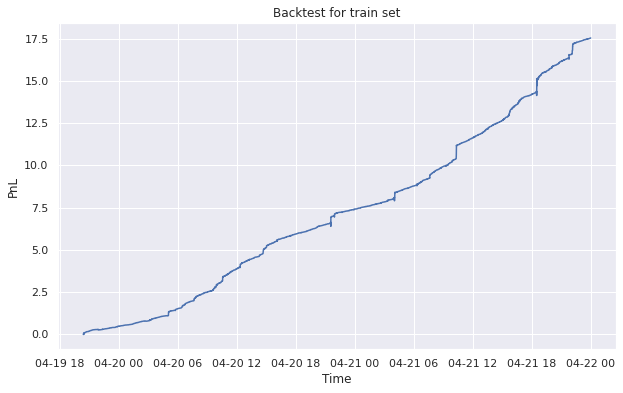

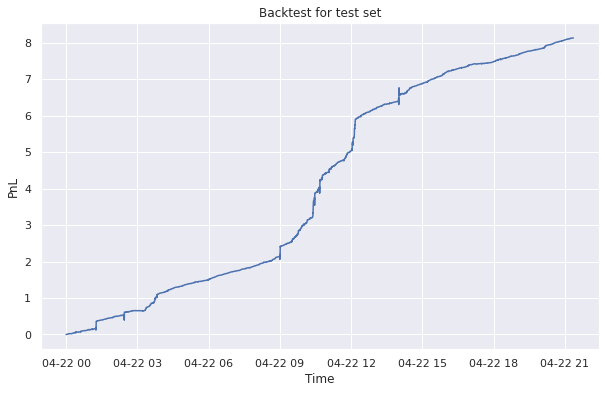

In [ ]:
model_reg = LinearRegression()
run_model(model_reg)

## Lasso

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


test MAE:  0.00024733853903651307
test MSE:  1.3673887052034078e-06
train R2:  0.0
test R2:  -1.2706866669986994e-09
train IC:  4.66736280185723e-17
test IC:  nan
train time:  0.014903545379638672


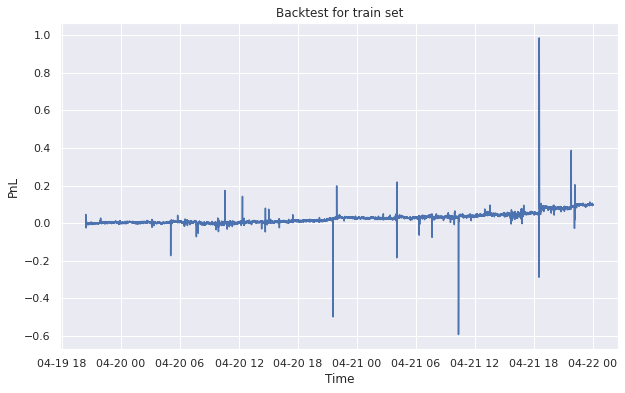

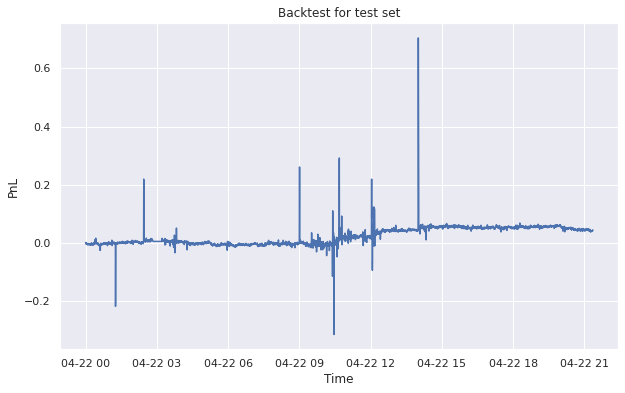

In [ ]:
model_reg = Lasso(alpha=1)
run_model(model_reg)

## Ridge

test MAE:  0.0002294250998454194
test MSE:  1.054128666304887e-06
train R2:  0.17070295579381312
test R2:  0.2290936266820005
train IC:  0.42373046057897285
test IC:  0.5131374258598154
train time:  0.01500082015991211


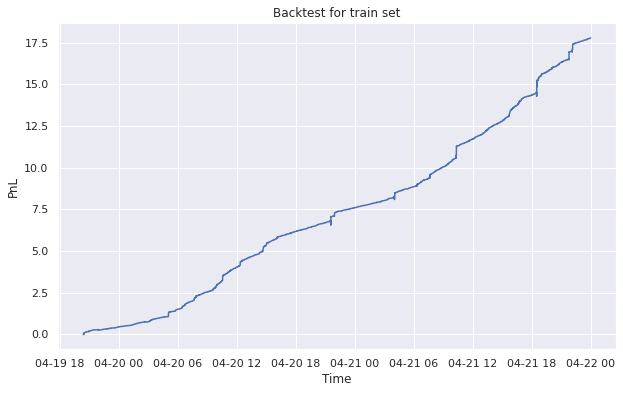

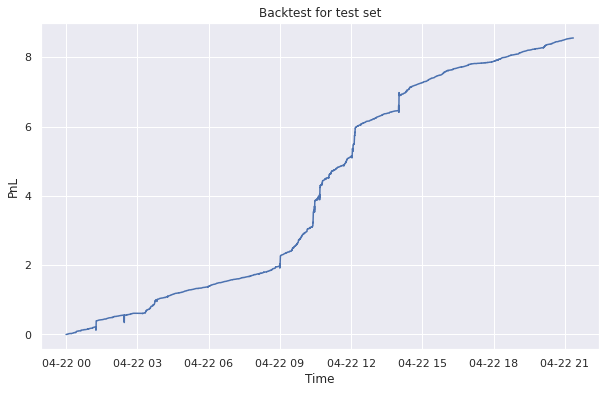

In [ ]:
model_reg = Ridge(alpha=0.1)
run_model(model_reg)

## Random Forest

test MAE:  0.00020500788375269
test MSE:  1.0194376324338669e-06
train R2:  0.6091826108191547
test R2:  0.254463906386001
train IC:  0.78381207950266
test IC:  0.5167248246307756
train time:  101.7073187828064


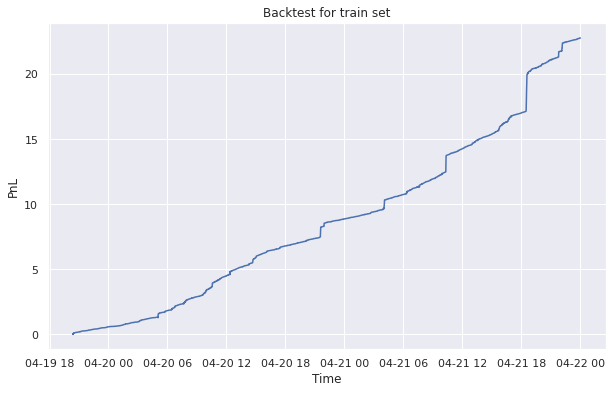

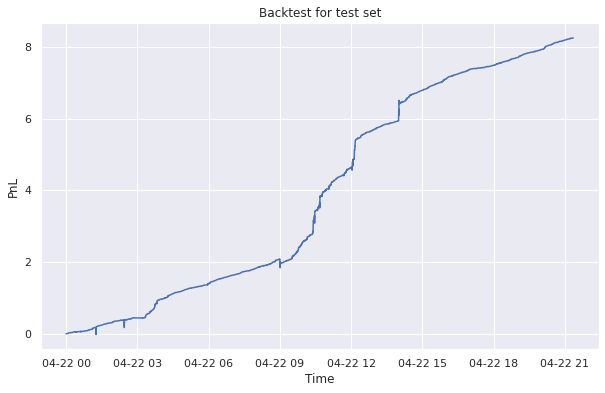

In [ ]:
rf = RandomForestRegressor(max_depth=10, 
                           min_samples_leaf=1,
                           min_samples_split=2, 
                           n_estimators=100)
run_model(rf)

----------------------
n=1
test MAE:  0.00020452714863965254
test MSE:  1.010658135013952e-06
train R2:  0.6096538777125206
test R2:  0.2608845367434566
train IC:  0.7840902656243401
test IC:  0.5206958972545267
train time:  101.9518735408783
----------------------
n=3
test MAE:  0.0002039486382962503
test MSE:  1.0069493732730153e-06
train R2:  0.6093551513823628
test R2:  0.2635968318878703
train IC:  0.7833680882439519
test IC:  0.5234907834663496
train time:  34.62225532531738
----------------------
n=5
test MAE:  0.00020563570530532846
test MSE:  1.0277263332224747e-06
train R2:  0.6105777312603302
test R2:  0.24840220588518613
train IC:  0.7845052882427371
test IC:  0.5142267739258243
train time:  23.39862561225891
----------------------
n=7
test MAE:  0.00020459291450922943
test MSE:  1.0114913891732792e-06
train R2:  0.6078768026253354
test R2:  0.26027516052350164
train IC:  0.7828543524363883
test IC:  0.5213605210203495
train time:  19.883806943893433


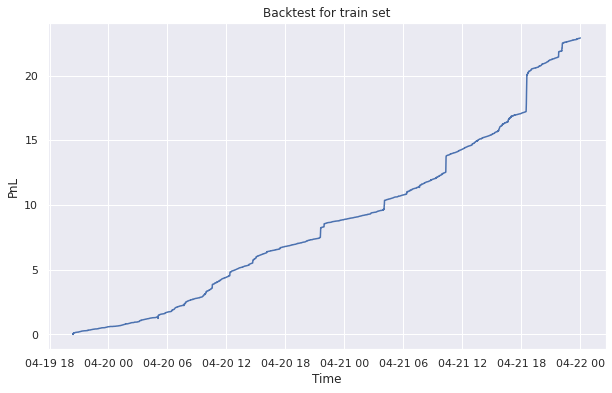

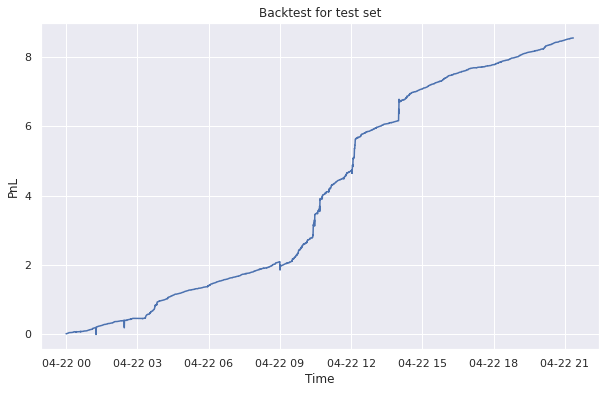

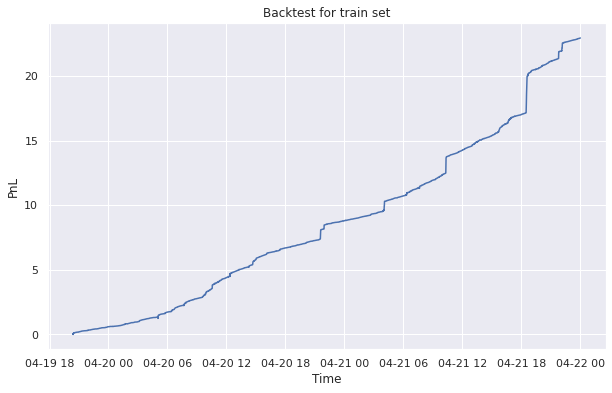

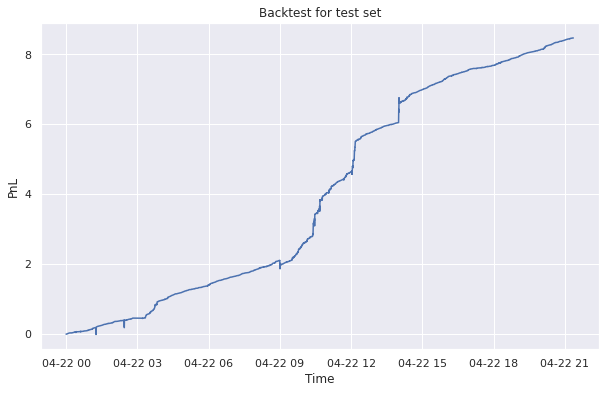

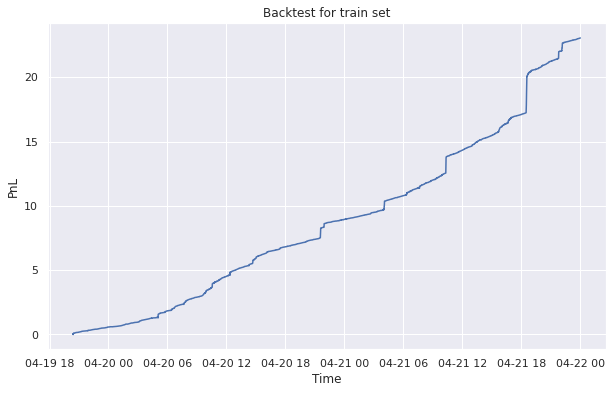

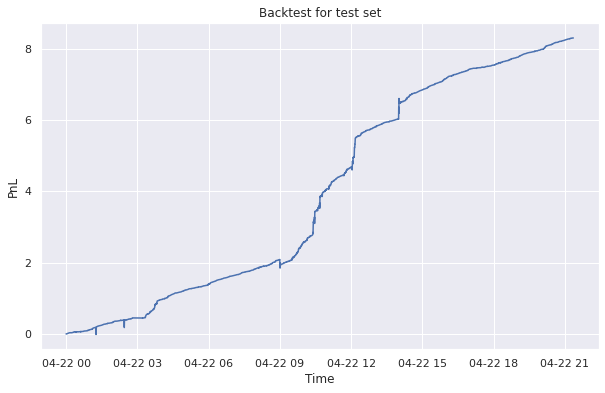

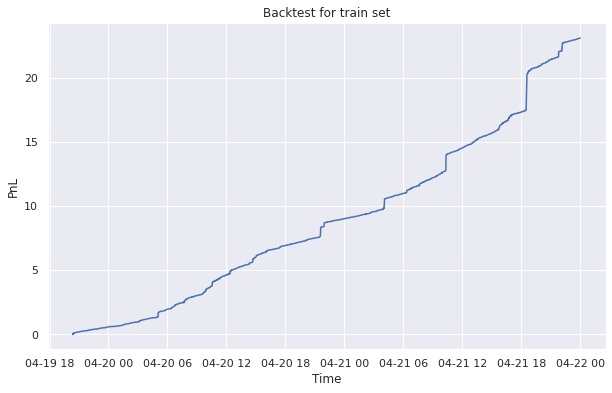

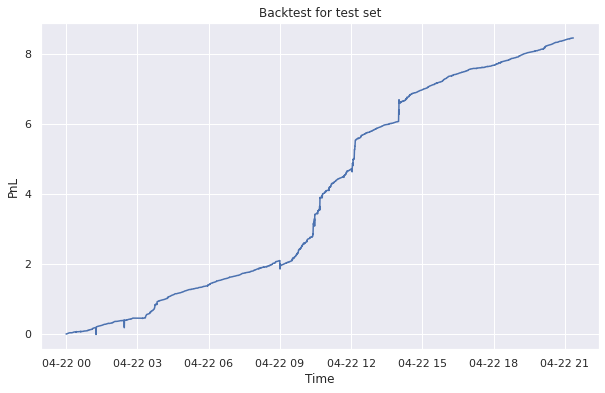

In [ ]:
for n in [1, 3, 5, 7]:
    rf = RandomForestRegressor(max_depth=10, 
                           min_samples_leaf=1,
                           min_samples_split=2, 
                           n_estimators=100,
                           n_jobs=n)
    print('----------------------')
    print(f'n={n}')
    run_model(rf)

## XGBoost

[05:02:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
test MAE:  0.0002110791055846441
test MSE:  9.696466838372404e-07
train R2:  0.4530296043365166
test R2:  0.2908770700097919
train IC:  0.682880489633268
test IC:  0.5393828032575302
train time:  9.617098808288574
[05:02:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


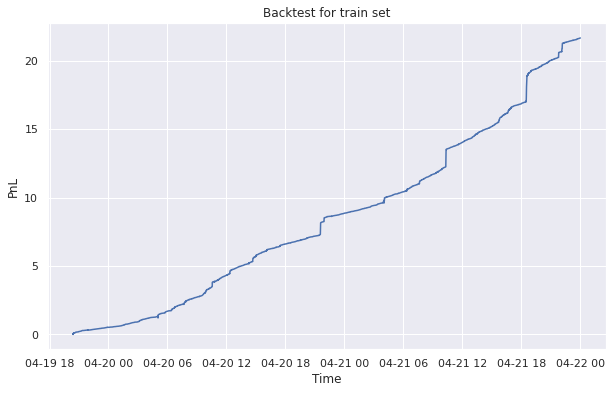

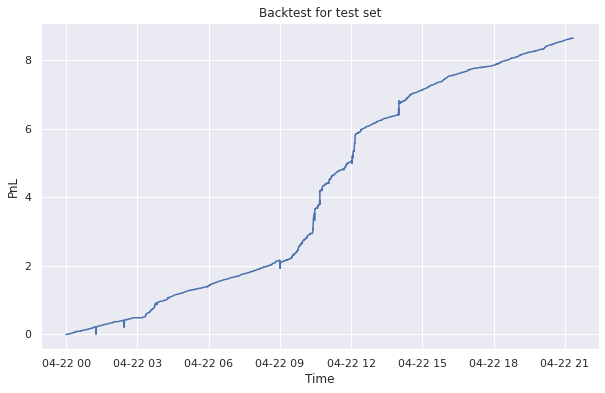

In [ ]:
xg = XGBRegressor(n_estimators=100)
run_model(xg, save_model=True, model_name='xgb.bin')

----------------------
n=1
[05:02:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
test MAE:  0.0002110791055846441
test MSE:  9.696466838372404e-07
train R2:  0.4530296043365166
test R2:  0.2908770700097919
train IC:  0.682880489633268
test IC:  0.5393828032575302
train time:  9.564026594161987
----------------------
n=3
[05:02:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
test MAE:  0.0002110791055846441
test MSE:  9.696466838372404e-07
train R2:  0.4530296043365166
test R2:  0.2908770700097919
train IC:  0.682880489633268
test IC:  0.5393828032575302
train time:  3.960399866104126
----------------------
n=5
[05:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
test MAE:  0.0002110791055846441
test MSE:  9.696466838372404e-07
train R2:  0.4530296043365166
test R2:  0.29

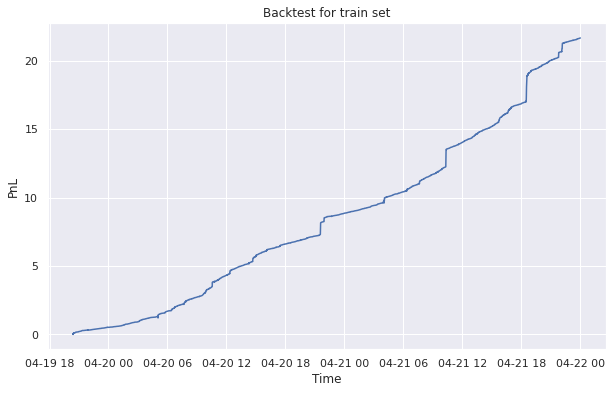

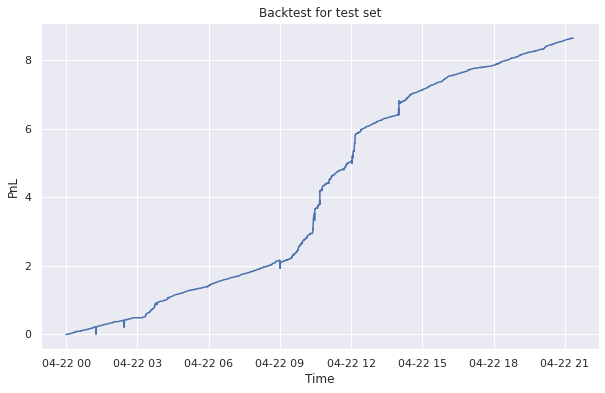

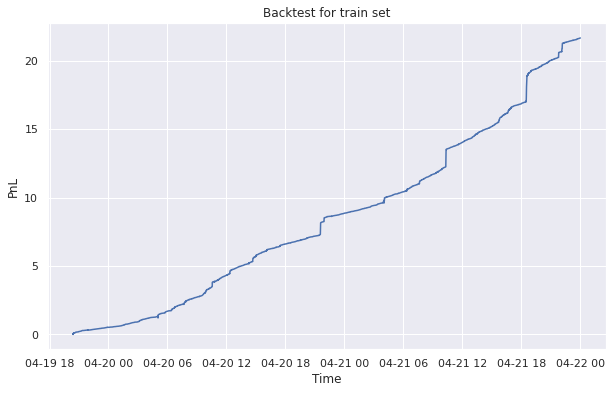

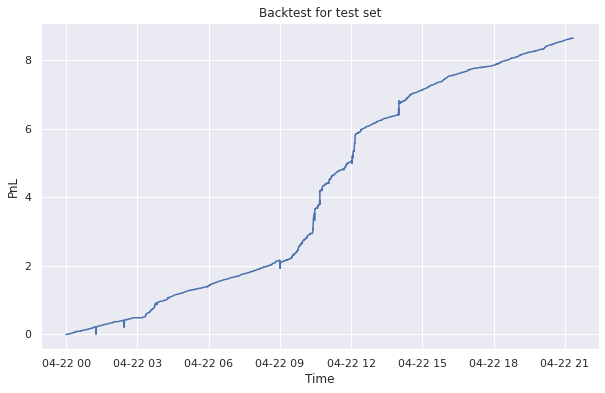

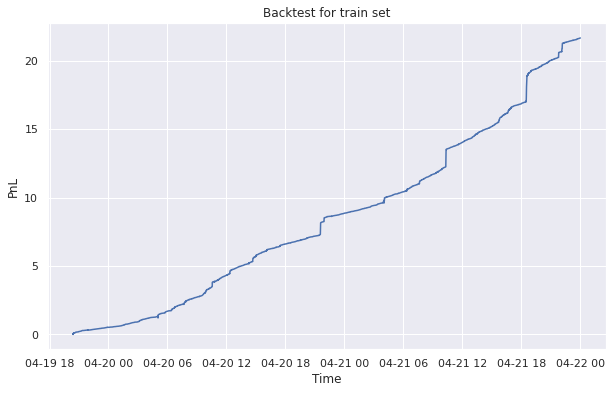

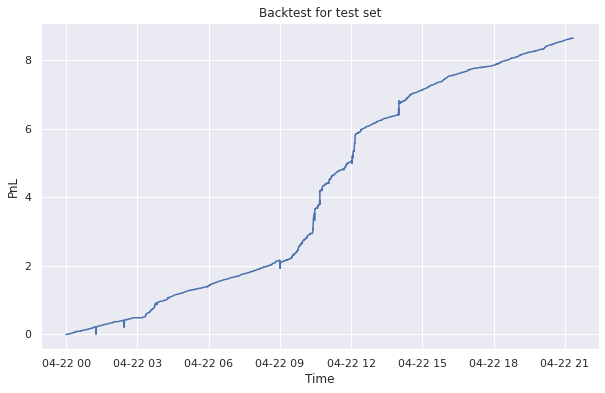

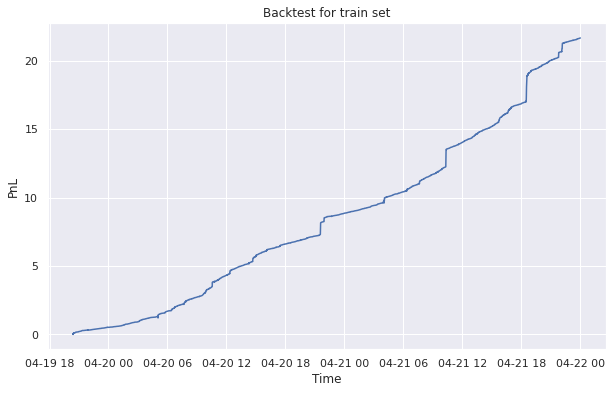

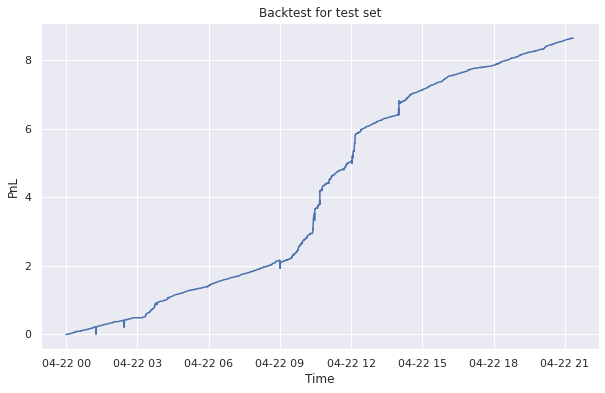

In [ ]:
for n in [1, 3, 5, 7]:
    xg = XGBRegressor(n_estimators=100, n_jobs=n)
    print('----------------------')
    print(f'n={n}')
    run_model(xg)

## LightGBM

test MAE:  0.0002239187490779346
test MSE:  1.1874752670078209e-06
train R2:  0.6046232121613454
test R2:  0.13157446452646748
train IC:  0.7853675862054313
test IC:  0.385887767669065
train time:  0.39850807189941406


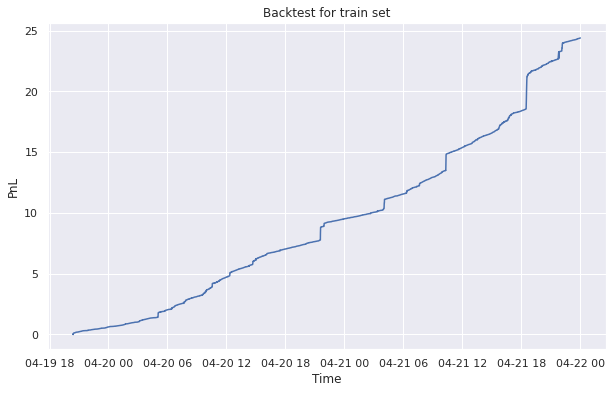

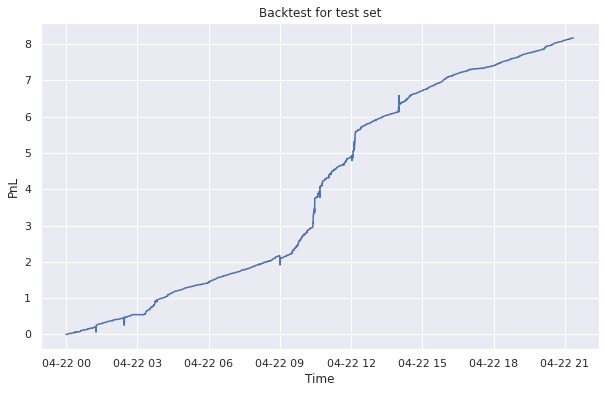

In [ ]:
lg = LGBMRegressor(n_estimators=100)
run_model(lg)

----------------------
n=1
test MAE:  0.0002239187490779346
test MSE:  1.1874752670078209e-06
train R2:  0.6046232121613454
test R2:  0.13157446452646748
train IC:  0.7853675862054313
test IC:  0.385887767669065
train time:  1.0218091011047363
----------------------
n=3
test MAE:  0.0002239187490779346
test MSE:  1.1874752670078209e-06
train R2:  0.6046232121613454
test R2:  0.13157446452646748
train IC:  0.7853675862054313
test IC:  0.385887767669065
train time:  0.4630117416381836
----------------------
n=5
test MAE:  0.0002239187490779346
test MSE:  1.1874752670078209e-06
train R2:  0.6046232121613454
test R2:  0.13157446452646748
train IC:  0.7853675862054313
test IC:  0.385887767669065
train time:  0.3700137138366699
----------------------
n=7
test MAE:  0.0002239187490779346
test MSE:  1.1874752670078209e-06
train R2:  0.6046232121613454
test R2:  0.13157446452646748
train IC:  0.7853675862054313
test IC:  0.385887767669065
train time:  0.3504941463470459


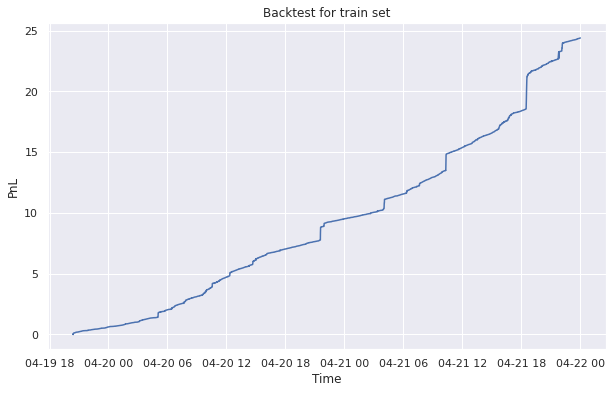

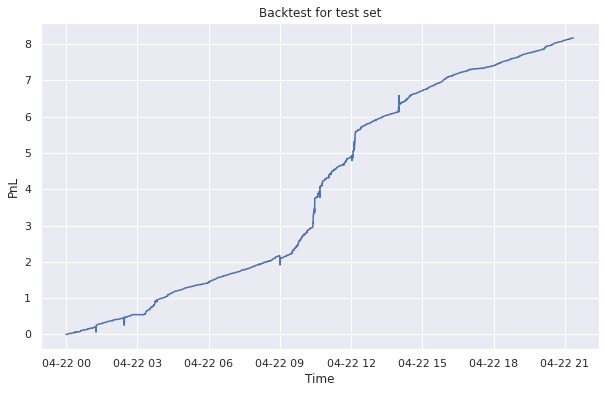

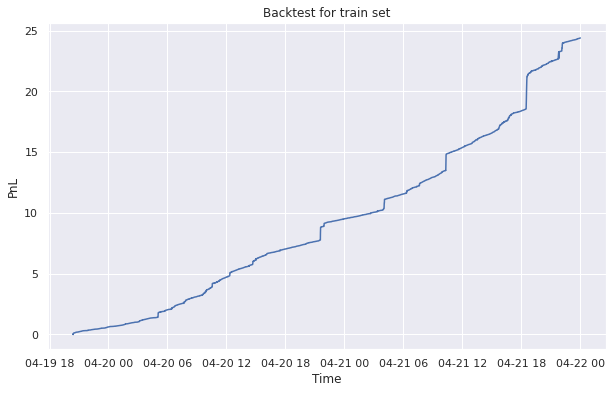

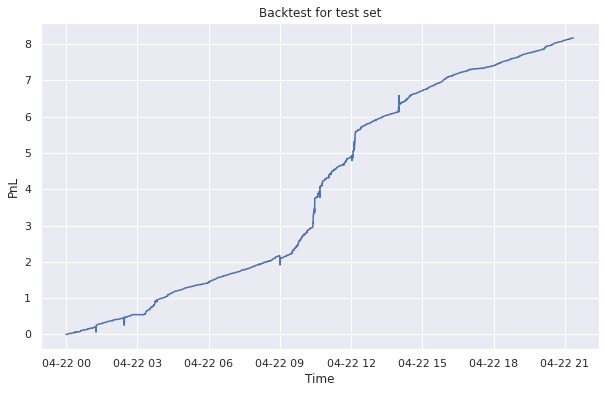

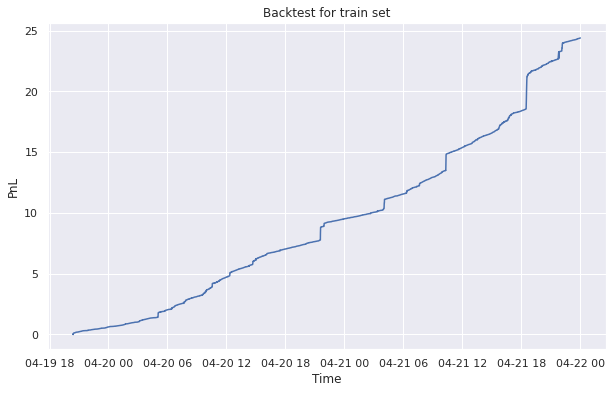

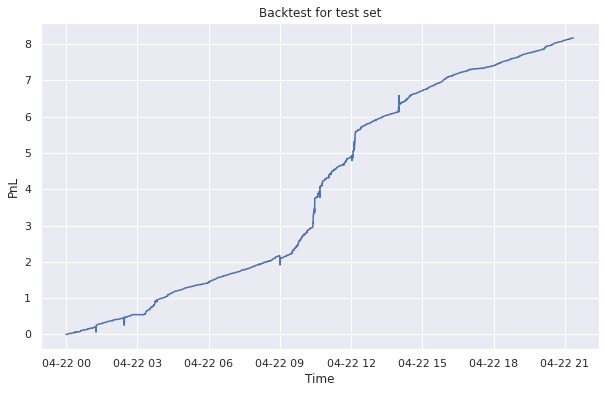

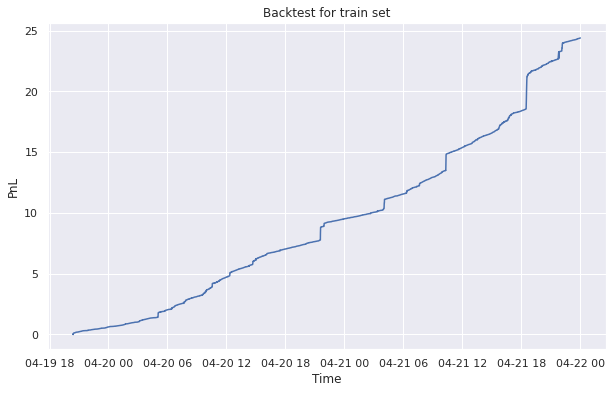

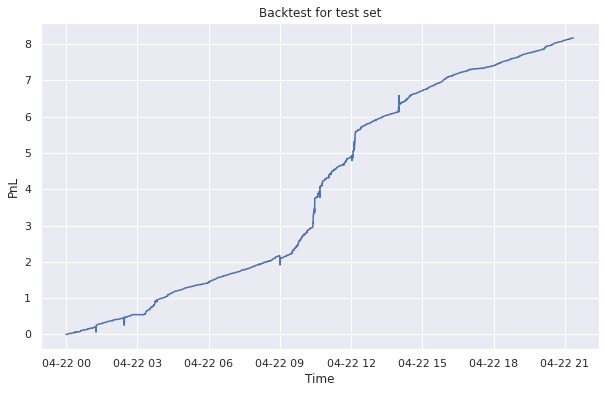

In [ ]:
for n in [1, 3, 5, 7]:
    lg = LGBMRegressor(n_estimators=100, n_jobs=n)
    print('----------------------')
    print(f'n={n}')
    run_model(lg)